In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/train"
val_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"
test_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the number of images in each dataset
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in validation dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))


Number of images in train dataset: 2000
Number of images in validation dataset: 600
Number of images in test dataset: 600


In [5]:
num_classes = len(train_dataset.classes)

In [6]:
import torch
import torch.nn as nn
from torchvision import models

from torchvision.models.vision_transformer import vit_b_16


class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        self.vit = vit_b_16(pretrained=True)

        # Access the first (and only) layer inside the Sequential `heads`
        in_features = self.vit.heads[0].in_features
        self.vit.heads = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

In [7]:
def calculate_metrics(labels, preds):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

In [8]:
def calculate_specificity_sensitivity(labels, preds):
    """Calculate sensitivity and specificity."""
    cfm = confusion_matrix(labels, preds)
    TP = cfm[1, 1]
    TN = cfm[0, 0]
    FP = cfm[0, 1]
    FN = cfm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero

    return sensitivity, specificity

In [9]:
import matplotlib.pyplot as plt

def plot_metrics(train_values, val_values, title, ylabel):
    plt.figure(figsize=(6, 4))  # Set the figure size
    plt.style.use('seaborn')  # Set the plot style
    plt.title(title, fontsize=16, fontweight='bold')  # Set the title
    plt.plot(train_values, label='Training', color='blue', linewidth=2)  # Plot training values
    plt.plot(val_values, label='Validation', color='orange', linewidth=2)  # Plot validation values
    plt.xlabel('Epochs', fontsize=14)  # Set the x-label
    plt.ylabel(ylabel, fontsize=14)  # Set the y-label
    plt.legend(fontsize=12)  # Add legend
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
    plt.show()  # Show the plot

In [10]:
def extract_features_and_labels(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            batch_labels = batch_labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            if isinstance(model, nn.DataParallel):
                output_features = model.module.get_features(images)
            else:
                output_features = model.get_features(images)
            features.extend(output_features.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return {'features': np.array(features), 'labels': np.array(labels)}

In [11]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.initial_alpha = 0.6
        self.initial_gamma = 3
        self.initial_ce_weight = 0.2
        self.initial_focal_weight = 0.9
        self.initial_smoothing = 0.1

    def forward(self, output, target, current_epoch, total_epochs):
        # Dynamic adjustments based on the epoch number
        decay_factor = current_epoch / total_epochs
        alpha = self.initial_alpha * (1 - decay_factor)  # Decrease alpha over time
        gamma = self.initial_gamma * (1 - decay_factor)  # Decrease gamma over time
        ce_weight = self.initial_ce_weight  # Could also be adjusted dynamically
        focal_weight = self.initial_focal_weight * (1 - decay_factor)  # Decrease focal weight
        smoothing = self.initial_smoothing * (1 - decay_factor)  # Decrease smoothing

        # Adjust class weights based on the frequency of each class
        class_counts = torch.zeros(self.num_classes, device=output.device)
        for c in range(self.num_classes):
            class_counts[c] = (target == c).sum()

        epsilon = 1e-6
        class_weights = 1.0 / (class_counts + epsilon)
        class_weights = class_weights / class_weights.sum()  # normalize to sum to 1

        # Compute log probabilities
        log_probs = F.log_softmax(output, dim=1)

        # Apply label smoothing
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1 - smoothing)

        # Compute the cross-entropy loss with label smoothing
        ce_loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))

        # Compute the focal component
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss

        # Combine the losses with respective weights
        total_loss = ce_weight * ce_loss + focal_weight * focal_loss

        return total_loss

In [12]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=1fcb6b27b526beeba873593871f8ed1e2ba885db327a7d4ed4b509ce1b6762a9
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=84e22f005223e1e571fe4d38e01be52123a84ace9de9cf44bd20ac4a73130346
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import time
import copy

# Define snapshot ensemble function
def snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device):

    ensemble_models = []
    snapshot_epochs = [30, 70, 120]
    best_snapshot_weights = None

    model = ViTClassifier(num_classes).to(device)
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    # FLOPs and parameter count
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    flops = FlopCountAnalysis(model, sample_input)
    print("Model FLOPs and Parameter Count:")
    print(parameter_count_table(model))
    print(f"Total FLOPs: {flops.total() / 1e9:.2f} GFLOPs")

    criterion = CustomLoss(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=snapshot_epochs[0], eta_min=1e-8)

    train_accs, val_accs, train_losses, val_losses, test_accs, test_losses = [], [], [], [], [], []
    learning_rates = []

    total_epochs = 120
    best_val_accuracy = 0

    for epoch in range(total_epochs):
        if epoch in snapshot_epochs and epoch != snapshot_epochs[-1]:
            optimizer = optim.Adam(model.parameters(), lr=0.0001)
            next_snapshot_index = snapshot_epochs.index(epoch) + 1
            epochs_until_next_snapshot = snapshot_epochs[next_snapshot_index] - epoch
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs_until_next_snapshot, eta_min=1e-8)

        lr_rate = optimizer.param_groups[0]['lr']
        learning_rates.append(lr_rate)
        print(f"Epoch {epoch + 1}/{total_epochs}, Learning Rate: {lr_rate}")

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels, epoch, total_epochs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_accuracy = train_correct / train_total
        train_accs.append(train_accuracy)
        train_losses.append(train_loss / train_total)

        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        print(f"Train Loss: {train_loss / train_total:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

        # Validation phase
        model.eval()
        torch.cuda.reset_peak_memory_stats(device)
        start_time = time.time()

        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels, epoch, total_epochs)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        end_time = time.time()
        inference_time = end_time - start_time
        memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)

        print(f"Validation Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

        val_accuracy = val_correct / val_total
        val_accs.append(val_accuracy)
        val_losses.append(val_loss / val_total)

        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation Loss: {val_loss / val_total:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_snapshot_weights = copy.deepcopy(model.state_dict())
            print("Best model updated based on validation accuracy")

        if epoch + 1 in snapshot_epochs:
            snapshot_count = snapshot_epochs.index(epoch + 1)
            ensemble_models.append(copy.deepcopy(model))
            torch.save(model.state_dict(), f'snapshot_{snapshot_count}_model.pth')
            print(f"Snapshot {snapshot_count} saved")

            model.load_state_dict(best_snapshot_weights)
            test_loss = 0
            test_correct = 0
            test_total = 0
            test_preds = []
            test_labels = []

            start_time = time.time()
            with torch.no_grad():
                for images, labels in tqdm(test_loader, desc="Testing"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels, epoch, total_epochs)
                    test_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
                    test_preds.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
            end_time = time.time()

            inference_time = end_time - start_time
            memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
            print(f"Test Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

            test_accuracy = test_correct / test_total
            test_accs.append(test_accuracy)
            test_losses.append(test_loss / test_total)

            test_precision = precision_score(test_labels, test_preds, average='weighted')
            test_recall = recall_score(test_labels, test_preds, average='weighted')
            test_f1 = f1_score(test_labels, test_preds, average='weighted')
            print(f"Test Loss: {test_loss / test_total:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

            print("Classification Report for Test Data:")
            print(classification_report(test_labels, test_preds))

            conf_matrix = confusion_matrix(test_labels, test_preds)
            conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            sensitivity, specificity = calculate_specificity_sensitivity(test_labels, test_preds)
            print(f"Test Sensitivity: {sensitivity:.4f}, Test Specificity: {specificity:.4f}")

            plot_metrics(train_accs, val_accs, 'Accuracy vs. Epochs', 'Accuracy')
            plot_metrics(train_losses, val_losses, 'Loss vs. Epochs', 'Loss')

            plt.figure(figsize=(6, 4))
            plt.plot(range(1, epoch + 2), learning_rates)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate vs. Epochs')
            plt.grid(True)
            plt.show()

        scheduler.step()

    return ensemble_models


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 202MB/s] 


Using 2 GPUs!
Model FLOPs and Parameter Count:
| name                      | #elements or shape   |
|:--------------------------|:---------------------|
| model                     | 85.8M                |
|  module                   |  85.8M               |
|   module.vit              |   85.8M              |
|    module.vit.class_token |    (1, 1, 768)       |
|    module.vit.conv_proj   |    0.6M              |
|    module.vit.encoder     |    85.2M             |
|    module.vit.heads       |    2.3K              |
Total FLOPs: 16.87 GFLOPs
Epoch 1/120, Learning Rate: 0.0001


Epoch 1/120: 100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Train Loss: 0.3431, Accuracy: 0.6530, Precision: 0.4774, Recall: 0.6530, F1 Score: 0.5496


Validation: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 6.27 sec, Peak GPU Memory: 1891.13 MB
Validation Loss: 0.3149, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Best model updated based on validation accuracy
Epoch 2/120, Learning Rate: 9.972612215893683e-05


Epoch 2/120: 100%|██████████| 16/16 [00:41<00:00,  2.60s/it]


Train Loss: 0.2468, Accuracy: 0.6985, Precision: 0.6858, Recall: 0.6985, F1 Score: 0.5946


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Validation Inference Time: 5.33 sec, Peak GPU Memory: 2219.87 MB
Validation Loss: 0.2613, Accuracy: 0.7283, Precision: 0.7211, Recall: 0.7283, F1 Score: 0.6990
Best model updated based on validation accuracy
Epoch 3/120, Learning Rate: 9.890748929868662e-05


Epoch 3/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.2088, Accuracy: 0.7620, Precision: 0.7415, Recall: 0.7620, F1 Score: 0.7349


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Validation Inference Time: 5.95 sec, Peak GPU Memory: 2219.18 MB
Validation Loss: 0.2329, Accuracy: 0.7333, Precision: 0.7074, Recall: 0.7333, F1 Score: 0.7122
Best model updated based on validation accuracy
Epoch 4/120, Learning Rate: 9.755307053217622e-05


Epoch 4/120: 100%|██████████| 16/16 [00:47<00:00,  2.94s/it]


Train Loss: 0.1709, Accuracy: 0.8350, Precision: 0.8283, Recall: 0.8350, F1 Score: 0.8256


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.68 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.3530, Accuracy: 0.5850, Precision: 0.6904, Recall: 0.5850, F1 Score: 0.6084
Epoch 5/120, Learning Rate: 9.567770515484182e-05


Epoch 5/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.1520, Accuracy: 0.8640, Precision: 0.8592, Recall: 0.8640, F1 Score: 0.8595


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.70 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2762, Accuracy: 0.7250, Precision: 0.7329, Recall: 0.7250, F1 Score: 0.6999
Epoch 6/120, Learning Rate: 9.330194006220303e-05


Epoch 6/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.1242, Accuracy: 0.9205, Precision: 0.9198, Recall: 0.9205, F1 Score: 0.9175


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.69 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2508, Accuracy: 0.7317, Precision: 0.7545, Recall: 0.7317, F1 Score: 0.7398
Epoch 7/120, Learning Rate: 9.045180463377551e-05


Epoch 7/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.1022, Accuracy: 0.9665, Precision: 0.9663, Recall: 0.9665, F1 Score: 0.9661


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Validation Inference Time: 5.79 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2887, Accuracy: 0.7333, Precision: 0.7216, Recall: 0.7333, F1 Score: 0.7226
Epoch 8/120, Learning Rate: 8.715852554974232e-05


Epoch 8/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0917, Accuracy: 0.9885, Precision: 0.9885, Recall: 0.9885, F1 Score: 0.9884


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.66 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2830, Accuracy: 0.7250, Precision: 0.7154, Recall: 0.7250, F1 Score: 0.7189
Epoch 9/120, Learning Rate: 8.345818466491112e-05


Epoch 9/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0860, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation Inference Time: 5.53 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2727, Accuracy: 0.7133, Precision: 0.7329, Recall: 0.7133, F1 Score: 0.7195
Epoch 10/120, Learning Rate: 7.939132368836219e-05


Epoch 10/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0833, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.68 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2894, Accuracy: 0.7017, Precision: 0.7318, Recall: 0.7017, F1 Score: 0.7093
Epoch 11/120, Learning Rate: 7.500249999999999e-05


Epoch 11/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0819, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.66 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2707, Accuracy: 0.7117, Precision: 0.7251, Recall: 0.7117, F1 Score: 0.7174
Epoch 12/120, Learning Rate: 7.033979847057463e-05


Epoch 12/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0809, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.72 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2637, Accuracy: 0.7333, Precision: 0.7376, Recall: 0.7333, F1 Score: 0.7353
Epoch 13/120, Learning Rate: 6.54543046337755e-05


Epoch 13/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0802, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.70 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2614, Accuracy: 0.7283, Precision: 0.7329, Recall: 0.7283, F1 Score: 0.7302
Epoch 14/120, Learning Rate: 6.039954498243388e-05


Epoch 14/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0795, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Validation Inference Time: 5.82 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2616, Accuracy: 0.7283, Precision: 0.7335, Recall: 0.7283, F1 Score: 0.7305
Epoch 15/120, Learning Rate: 5.5230900521066344e-05


Epoch 15/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0788, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.58 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2614, Accuracy: 0.7317, Precision: 0.7355, Recall: 0.7317, F1 Score: 0.7333
Epoch 16/120, Learning Rate: 5.000500000000001e-05


Epoch 16/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0782, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation Inference Time: 5.60 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2619, Accuracy: 0.7300, Precision: 0.7334, Recall: 0.7300, F1 Score: 0.7314
Epoch 17/120, Learning Rate: 4.4779099478933676e-05


Epoch 17/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0775, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.65 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2614, Accuracy: 0.7283, Precision: 0.7298, Recall: 0.7283, F1 Score: 0.7288
Epoch 18/120, Learning Rate: 3.961045501756612e-05


Epoch 18/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0769, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.64 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2608, Accuracy: 0.7283, Precision: 0.7313, Recall: 0.7283, F1 Score: 0.7295
Epoch 19/120, Learning Rate: 3.455569536622451e-05


Epoch 19/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0763, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation Inference Time: 5.60 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2611, Accuracy: 0.7283, Precision: 0.7298, Recall: 0.7283, F1 Score: 0.7287
Epoch 20/120, Learning Rate: 2.967020152942538e-05


Epoch 20/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0757, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.74 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2607, Accuracy: 0.7300, Precision: 0.7321, Recall: 0.7300, F1 Score: 0.7307
Epoch 21/120, Learning Rate: 2.5007500000000014e-05


Epoch 21/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0751, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.70 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2603, Accuracy: 0.7317, Precision: 0.7332, Recall: 0.7317, F1 Score: 0.7320
Epoch 22/120, Learning Rate: 2.0618676311637815e-05


Epoch 22/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0745, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.72 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2607, Accuracy: 0.7300, Precision: 0.7333, Recall: 0.7300, F1 Score: 0.7312
Epoch 23/120, Learning Rate: 1.6551815335088904e-05


Epoch 23/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0739, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.67 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2600, Accuracy: 0.7283, Precision: 0.7315, Recall: 0.7283, F1 Score: 0.7294
Epoch 24/120, Learning Rate: 1.285147445025769e-05


Epoch 24/120: 100%|██████████| 16/16 [00:47<00:00,  3.00s/it]


Train Loss: 0.0733, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.66 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2593, Accuracy: 0.7283, Precision: 0.7315, Recall: 0.7283, F1 Score: 0.7294
Epoch 25/120, Learning Rate: 9.558195366224511e-06


Epoch 25/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0727, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation Inference Time: 5.62 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2583, Accuracy: 0.7283, Precision: 0.7315, Recall: 0.7283, F1 Score: 0.7294
Epoch 26/120, Learning Rate: 6.7080599377969894e-06


Epoch 26/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0721, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.67 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2577, Accuracy: 0.7300, Precision: 0.7338, Recall: 0.7300, F1 Score: 0.7314
Epoch 27/120, Learning Rate: 4.3322948451581655e-06


Epoch 27/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0715, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.68 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2565, Accuracy: 0.7317, Precision: 0.7349, Recall: 0.7317, F1 Score: 0.7328
Epoch 28/120, Learning Rate: 2.4569294678237997e-06


Epoch 28/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0709, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation Inference Time: 5.60 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2554, Accuracy: 0.7317, Precision: 0.7349, Recall: 0.7317, F1 Score: 0.7328
Epoch 29/120, Learning Rate: 1.1025107013133848e-06


Epoch 29/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0702, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.72 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2542, Accuracy: 0.7317, Precision: 0.7349, Recall: 0.7317, F1 Score: 0.7328
Epoch 30/120, Learning Rate: 2.838778410631714e-07


Epoch 30/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0696, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.69 sec, Peak GPU Memory: 2220.71 MB
Validation Loss: 0.2529, Accuracy: 0.7317, Precision: 0.7349, Recall: 0.7317, F1 Score: 0.7328
Snapshot 0 saved


Testing: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Test Inference Time: 5.69 sec, Peak GPU Memory: 2549.94 MB
Test Loss: 0.2104, Accuracy: 0.7333, Precision: 0.7074, Recall: 0.7333, F1 Score: 0.7122
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.48      0.26      0.34       117
           1       0.79      0.89      0.84       393
           2       0.64      0.67      0.65        90

    accuracy                           0.73       600
   macro avg       0.64      0.61      0.61       600
weighted avg       0.71      0.73      0.71       600



Test Sensitivity: 0.9332, Test Specificity: 0.3039


<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


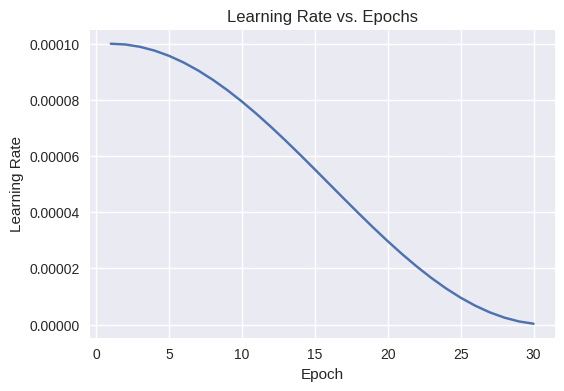

Epoch 31/120, Learning Rate: 0.0001


Epoch 31/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.2946, Accuracy: 0.6720, Precision: 0.6009, Recall: 0.6720, F1 Score: 0.5992


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 5.75 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2952, Accuracy: 0.6550, Precision: 0.4290, Recall: 0.6550, F1 Score: 0.5185
Epoch 32/120, Learning Rate: 9.984588209998774e-05


Epoch 32/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.2213, Accuracy: 0.6990, Precision: 0.6486, Recall: 0.6990, F1 Score: 0.6238


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Validation Inference Time: 5.80 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2359, Accuracy: 0.7083, Precision: 0.6798, Recall: 0.7083, F1 Score: 0.6637
Epoch 33/120, Learning Rate: 9.938447858805392e-05


Epoch 33/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.1789, Accuracy: 0.7815, Precision: 0.7653, Recall: 0.7815, F1 Score: 0.7570


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.71 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2303, Accuracy: 0.7183, Precision: 0.6862, Recall: 0.7183, F1 Score: 0.6645
Epoch 34/120, Learning Rate: 9.861863417028185e-05


Epoch 34/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.1489, Accuracy: 0.8305, Precision: 0.8226, Recall: 0.8305, F1 Score: 0.8201


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation Inference Time: 5.61 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2390, Accuracy: 0.6667, Precision: 0.6989, Recall: 0.6667, F1 Score: 0.6787
Epoch 35/120, Learning Rate: 9.755307053217622e-05


Epoch 35/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.1111, Accuracy: 0.9120, Precision: 0.9099, Recall: 0.9120, F1 Score: 0.9098


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.57 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2484, Accuracy: 0.7133, Precision: 0.7148, Recall: 0.7133, F1 Score: 0.7138
Epoch 36/120, Learning Rate: 9.619435722790178e-05


Epoch 36/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.1069, Accuracy: 0.9145, Precision: 0.9132, Recall: 0.9145, F1 Score: 0.9104


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.74 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.3137, Accuracy: 0.6150, Precision: 0.7311, Recall: 0.6150, F1 Score: 0.6375
Epoch 37/120, Learning Rate: 9.455087117679744e-05


Epoch 37/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0907, Accuracy: 0.9550, Precision: 0.9547, Recall: 0.9550, F1 Score: 0.9543


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.66 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.3004, Accuracy: 0.6650, Precision: 0.7282, Recall: 0.6650, F1 Score: 0.6833
Epoch 38/120, Learning Rate: 9.263274501688284e-05


Epoch 38/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0752, Accuracy: 0.9845, Precision: 0.9845, Recall: 0.9845, F1 Score: 0.9844


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.69 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2708, Accuracy: 0.6767, Precision: 0.7054, Recall: 0.6767, F1 Score: 0.6844
Epoch 39/120, Learning Rate: 9.04518046337755e-05


Epoch 39/120: 100%|██████████| 16/16 [00:47<00:00,  2.99s/it]


Train Loss: 0.0682, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.74 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2993, Accuracy: 0.6683, Precision: 0.6982, Recall: 0.6683, F1 Score: 0.6794
Epoch 40/120, Learning Rate: 8.802149625017354e-05


Epoch 40/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0661, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.66 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2769, Accuracy: 0.7067, Precision: 0.6956, Recall: 0.7067, F1 Score: 0.7002
Epoch 41/120, Learning Rate: 8.535680352542143e-05


Epoch 41/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0642, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.77 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2929, Accuracy: 0.6917, Precision: 0.7045, Recall: 0.6917, F1 Score: 0.6907
Epoch 42/120, Learning Rate: 8.247415517626753e-05


Epoch 42/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0630, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.66 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2999, Accuracy: 0.6800, Precision: 0.7085, Recall: 0.6800, F1 Score: 0.6905
Epoch 43/120, Learning Rate: 7.939132368836218e-05


Epoch 43/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0624, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.64 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.3190, Accuracy: 0.6567, Precision: 0.6936, Recall: 0.6567, F1 Score: 0.6691
Epoch 44/120, Learning Rate: 7.612731574297384e-05


Epoch 44/120: 100%|██████████| 16/16 [00:47<00:00,  2.99s/it]


Train Loss: 0.0616, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation Inference Time: 5.62 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2777, Accuracy: 0.7117, Precision: 0.7126, Recall: 0.7117, F1 Score: 0.7119
Epoch 45/120, Learning Rate: 7.270225503447863e-05


Epoch 45/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0607, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation Inference Time: 5.61 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2795, Accuracy: 0.7000, Precision: 0.7229, Recall: 0.7000, F1 Score: 0.7078
Epoch 46/120, Learning Rate: 6.913725820109265e-05


Epoch 46/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0602, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.77 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2708, Accuracy: 0.7167, Precision: 0.7115, Recall: 0.7167, F1 Score: 0.7123
Epoch 47/120, Learning Rate: 6.54543046337755e-05


Epoch 47/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0595, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.75 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2850, Accuracy: 0.6933, Precision: 0.6916, Recall: 0.6933, F1 Score: 0.6923
Epoch 48/120, Learning Rate: 6.167610096597599e-05


Epoch 48/120: 100%|██████████| 16/16 [00:47<00:00,  2.99s/it]


Train Loss: 0.0596, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.69 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2753, Accuracy: 0.7100, Precision: 0.7040, Recall: 0.7100, F1 Score: 0.7052
Epoch 49/120, Learning Rate: 5.782594107968634e-05


Epoch 49/120: 100%|██████████| 16/16 [00:48<00:00,  3.01s/it]


Train Loss: 0.0623, Accuracy: 0.9900, Precision: 0.9900, Recall: 0.9900, F1 Score: 0.9900


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Validation Inference Time: 5.82 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2750, Accuracy: 0.7117, Precision: 0.7039, Recall: 0.7117, F1 Score: 0.7067
Epoch 50/120, Learning Rate: 5.392756249091361e-05


Epoch 50/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0657, Accuracy: 0.9820, Precision: 0.9820, Recall: 0.9820, F1 Score: 0.9820


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.69 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2808, Accuracy: 0.7167, Precision: 0.6950, Recall: 0.7167, F1 Score: 0.6977
Epoch 51/120, Learning Rate: 5.0005e-05


Epoch 51/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0580, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.65 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2891, Accuracy: 0.6833, Precision: 0.6950, Recall: 0.6833, F1 Score: 0.6858
Epoch 52/120, Learning Rate: 4.60824375090864e-05


Epoch 52/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0565, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.72 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.3052, Accuracy: 0.6750, Precision: 0.6987, Recall: 0.6750, F1 Score: 0.6825
Epoch 53/120, Learning Rate: 4.218405892031367e-05


Epoch 53/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0553, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.66 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2887, Accuracy: 0.6833, Precision: 0.7029, Recall: 0.6833, F1 Score: 0.6900
Epoch 54/120, Learning Rate: 3.833389903402401e-05


Epoch 54/120: 100%|██████████| 16/16 [00:48<00:00,  3.00s/it]


Train Loss: 0.0546, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.74 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2755, Accuracy: 0.6917, Precision: 0.7006, Recall: 0.6917, F1 Score: 0.6938
Epoch 55/120, Learning Rate: 3.4555695366224505e-05


Epoch 55/120: 100%|██████████| 16/16 [00:48<00:00,  3.00s/it]


Train Loss: 0.0538, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.76 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2745, Accuracy: 0.6967, Precision: 0.6992, Recall: 0.6967, F1 Score: 0.6959
Epoch 56/120, Learning Rate: 3.087274179890734e-05


Epoch 56/120: 100%|██████████| 16/16 [00:48<00:00,  3.01s/it]


Train Loss: 0.0532, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.70 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2748, Accuracy: 0.6883, Precision: 0.6943, Recall: 0.6883, F1 Score: 0.6898
Epoch 57/120, Learning Rate: 2.730774496552136e-05


Epoch 57/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0525, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Validation Inference Time: 5.87 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2731, Accuracy: 0.6900, Precision: 0.6953, Recall: 0.6900, F1 Score: 0.6912
Epoch 58/120, Learning Rate: 2.388268425702614e-05


Epoch 58/120: 100%|██████████| 16/16 [00:47<00:00,  2.99s/it]


Train Loss: 0.0518, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.75 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2716, Accuracy: 0.6933, Precision: 0.6975, Recall: 0.6933, F1 Score: 0.6941
Epoch 59/120, Learning Rate: 2.061867631163781e-05


Epoch 59/120: 100%|██████████| 16/16 [00:47<00:00,  3.00s/it]


Train Loss: 0.0511, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Validation Inference Time: 5.95 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2701, Accuracy: 0.6967, Precision: 0.6997, Recall: 0.6967, F1 Score: 0.6969
Epoch 60/120, Learning Rate: 1.7535844823732476e-05


Epoch 60/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0504, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.73 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2686, Accuracy: 0.6967, Precision: 0.6997, Recall: 0.6967, F1 Score: 0.6969
Epoch 61/120, Learning Rate: 1.465319647457856e-05


Epoch 61/120: 100%|██████████| 16/16 [00:47<00:00,  2.99s/it]


Train Loss: 0.0497, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.75 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2672, Accuracy: 0.6967, Precision: 0.6997, Recall: 0.6967, F1 Score: 0.6969
Epoch 62/120, Learning Rate: 1.1988503749826454e-05


Epoch 62/120: 100%|██████████| 16/16 [00:47<00:00,  2.99s/it]


Train Loss: 0.0491, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.74 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2657, Accuracy: 0.6983, Precision: 0.7007, Recall: 0.6983, F1 Score: 0.6983
Epoch 63/120, Learning Rate: 9.558195366224508e-06


Epoch 63/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0484, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.75 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2641, Accuracy: 0.7000, Precision: 0.7018, Recall: 0.7000, F1 Score: 0.6998
Epoch 64/120, Learning Rate: 7.377254983117161e-06


Epoch 64/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0477, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.73 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2627, Accuracy: 0.7000, Precision: 0.7018, Recall: 0.7000, F1 Score: 0.6998
Epoch 65/120, Learning Rate: 5.459128823202552e-06


Epoch 65/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0470, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.69 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2612, Accuracy: 0.7000, Precision: 0.7018, Recall: 0.7000, F1 Score: 0.6998
Epoch 66/120, Learning Rate: 3.8156427720982195e-06


Epoch 66/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0463, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Validation Inference Time: 5.82 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2596, Accuracy: 0.6983, Precision: 0.6994, Recall: 0.6983, F1 Score: 0.6977
Epoch 67/120, Learning Rate: 2.456929467823799e-06


Epoch 67/120: 100%|██████████| 16/16 [00:48<00:00,  3.00s/it]


Train Loss: 0.0456, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Validation Inference Time: 5.81 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2580, Accuracy: 0.6983, Precision: 0.6994, Recall: 0.6983, F1 Score: 0.6977
Epoch 68/120, Learning Rate: 1.3913658297181604e-06


Epoch 68/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0449, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.76 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2562, Accuracy: 0.6983, Precision: 0.6994, Recall: 0.6983, F1 Score: 0.6977
Epoch 69/120, Learning Rate: 6.255214119460928e-07


Epoch 69/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0442, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Validation Inference Time: 5.75 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2542, Accuracy: 0.6983, Precision: 0.6994, Recall: 0.6983, F1 Score: 0.6977
Epoch 70/120, Learning Rate: 1.6411790001226747e-07


Epoch 70/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0435, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.66 sec, Peak GPU Memory: 2550.99 MB
Validation Loss: 0.2522, Accuracy: 0.6983, Precision: 0.6994, Recall: 0.6983, F1 Score: 0.6977
Snapshot 1 saved


Testing: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Test Inference Time: 5.67 sec, Peak GPU Memory: 2881.32 MB
Test Loss: 0.1706, Accuracy: 0.7333, Precision: 0.7074, Recall: 0.7333, F1 Score: 0.7122
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.48      0.26      0.34       117
           1       0.79      0.89      0.84       393
           2       0.64      0.67      0.65        90

    accuracy                           0.73       600
   macro avg       0.64      0.61      0.61       600
weighted avg       0.71      0.73      0.71       600



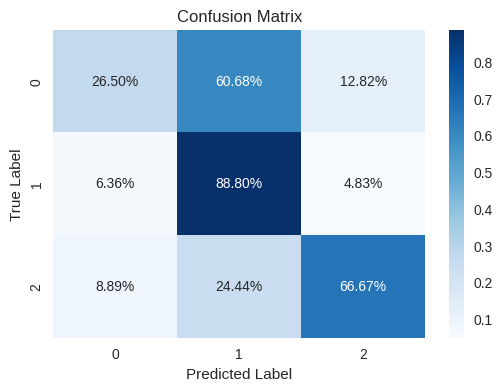

Test Sensitivity: 0.9332, Test Specificity: 0.3039


<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


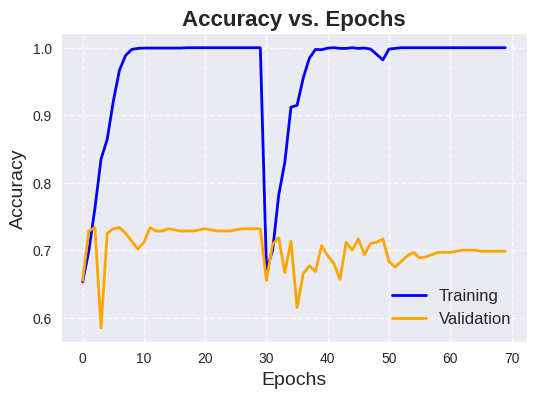

<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


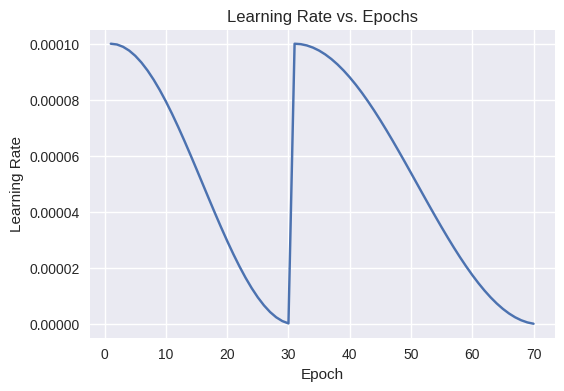

Epoch 71/120, Learning Rate: 0.0001


Epoch 71/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.2170, Accuracy: 0.6750, Precision: 0.6110, Recall: 0.6750, F1 Score: 0.6109


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 5.58 sec, Peak GPU Memory: 2881.28 MB
Validation Loss: 0.2001, Accuracy: 0.6883, Precision: 0.5609, Recall: 0.6883, F1 Score: 0.6176
Epoch 72/120, Learning Rate: 9.990134628777144e-05


Epoch 72/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.1603, Accuracy: 0.7520, Precision: 0.7299, Recall: 0.7520, F1 Score: 0.6991


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.66 sec, Peak GPU Memory: 2880.76 MB
Validation Loss: 0.1802, Accuracy: 0.6983, Precision: 0.6869, Recall: 0.6983, F1 Score: 0.6772
Epoch 73/120, Learning Rate: 9.960577449221733e-05


Epoch 73/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.1279, Accuracy: 0.8160, Precision: 0.8044, Recall: 0.8160, F1 Score: 0.7990


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.54 sec, Peak GPU Memory: 2880.76 MB
Validation Loss: 0.1638, Accuracy: 0.7483, Precision: 0.7339, Recall: 0.7483, F1 Score: 0.7376
Best model updated based on validation accuracy
Epoch 74/120, Learning Rate: 9.91144511001808e-05


Epoch 74/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0978, Accuracy: 0.8845, Precision: 0.8795, Recall: 0.8845, F1 Score: 0.8788


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation Inference Time: 5.52 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.1878, Accuracy: 0.7217, Precision: 0.7051, Recall: 0.7217, F1 Score: 0.6936
Epoch 75/120, Learning Rate: 9.84293151406259e-05


Epoch 75/120: 100%|██████████| 16/16 [00:47<00:00,  2.94s/it]


Train Loss: 0.0723, Accuracy: 0.9400, Precision: 0.9395, Recall: 0.9400, F1 Score: 0.9386


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation Inference Time: 5.61 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2523, Accuracy: 0.6450, Precision: 0.7244, Recall: 0.6450, F1 Score: 0.6649
Epoch 76/120, Learning Rate: 9.75530705321762e-05


Epoch 76/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0591, Accuracy: 0.9635, Precision: 0.9631, Recall: 0.9635, F1 Score: 0.9631


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.57 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2242, Accuracy: 0.7233, Precision: 0.7443, Recall: 0.7233, F1 Score: 0.7304
Epoch 77/120, Learning Rate: 9.648917541198312e-05


Epoch 77/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0476, Accuracy: 0.9860, Precision: 0.9860, Recall: 0.9860, F1 Score: 0.9860


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.63 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2316, Accuracy: 0.7033, Precision: 0.7190, Recall: 0.7033, F1 Score: 0.7040
Epoch 78/120, Learning Rate: 9.524182848803865e-05


Epoch 78/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0462, Accuracy: 0.9840, Precision: 0.9839, Recall: 0.9840, F1 Score: 0.9839


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Validation Inference Time: 5.72 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2315, Accuracy: 0.6817, Precision: 0.6924, Recall: 0.6817, F1 Score: 0.6832
Epoch 79/120, Learning Rate: 9.381595246879295e-05


Epoch 79/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0421, Accuracy: 0.9910, Precision: 0.9910, Recall: 0.9910, F1 Score: 0.9910


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.64 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2255, Accuracy: 0.7067, Precision: 0.7565, Recall: 0.7067, F1 Score: 0.7220
Epoch 80/120, Learning Rate: 9.221717463547324e-05


Epoch 80/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0397, Accuracy: 0.9945, Precision: 0.9945, Recall: 0.9945, F1 Score: 0.9945


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.57 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2268, Accuracy: 0.7083, Precision: 0.7227, Recall: 0.7083, F1 Score: 0.7141
Epoch 81/120, Learning Rate: 9.04518046337755e-05


Epoch 81/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0380, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.47 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2324, Accuracy: 0.7000, Precision: 0.7141, Recall: 0.7000, F1 Score: 0.7051
Epoch 82/120, Learning Rate: 8.852680957257558e-05


Epoch 82/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0364, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.48 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2324, Accuracy: 0.7233, Precision: 0.7251, Recall: 0.7233, F1 Score: 0.7205
Epoch 83/120, Learning Rate: 8.644978652793345e-05


Epoch 83/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0389, Accuracy: 0.9900, Precision: 0.9900, Recall: 0.9900, F1 Score: 0.9900


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.48 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2341, Accuracy: 0.6917, Precision: 0.7180, Recall: 0.6917, F1 Score: 0.7008
Epoch 84/120, Learning Rate: 8.422893256090478e-05


Epoch 84/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0389, Accuracy: 0.9900, Precision: 0.9900, Recall: 0.9900, F1 Score: 0.9900


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.47 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2194, Accuracy: 0.7000, Precision: 0.7172, Recall: 0.7000, F1 Score: 0.7064
Epoch 85/120, Learning Rate: 8.187301236748573e-05


Epoch 85/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0393, Accuracy: 0.9850, Precision: 0.9850, Recall: 0.9850, F1 Score: 0.9850


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.54 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2334, Accuracy: 0.6950, Precision: 0.7003, Recall: 0.6950, F1 Score: 0.6971
Epoch 86/120, Learning Rate: 7.939132368836219e-05


Epoch 86/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0356, Accuracy: 0.9960, Precision: 0.9961, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation Inference Time: 5.62 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2403, Accuracy: 0.6900, Precision: 0.7173, Recall: 0.6900, F1 Score: 0.6979
Epoch 87/120, Learning Rate: 7.679366061497492e-05


Epoch 87/120: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Train Loss: 0.0328, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.55 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2708, Accuracy: 0.6517, Precision: 0.7069, Recall: 0.6517, F1 Score: 0.6664
Epoch 88/120, Learning Rate: 7.409027493671524e-05


Epoch 88/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0310, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation Inference Time: 5.52 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2381, Accuracy: 0.6900, Precision: 0.7227, Recall: 0.6900, F1 Score: 0.7010
Epoch 89/120, Learning Rate: 7.12918356817958e-05


Epoch 89/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0297, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Validation Inference Time: 5.39 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2245, Accuracy: 0.7300, Precision: 0.7267, Recall: 0.7300, F1 Score: 0.7281
Epoch 90/120, Learning Rate: 6.840938701147047e-05


Epoch 90/120: 100%|██████████| 16/16 [00:46<00:00,  2.94s/it]


Train Loss: 0.0288, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.48 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2271, Accuracy: 0.7283, Precision: 0.7326, Recall: 0.7283, F1 Score: 0.7295
Epoch 91/120, Learning Rate: 6.545430463377548e-05


Epoch 91/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0280, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation Inference Time: 5.52 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2212, Accuracy: 0.7267, Precision: 0.7288, Recall: 0.7267, F1 Score: 0.7271
Epoch 92/120, Learning Rate: 6.243825090880689e-05


Epoch 92/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0271, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation Inference Time: 5.51 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2192, Accuracy: 0.7300, Precision: 0.7294, Recall: 0.7300, F1 Score: 0.7295
Epoch 93/120, Learning Rate: 5.93731288227133e-05


Epoch 93/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0263, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.54 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2180, Accuracy: 0.7300, Precision: 0.7278, Recall: 0.7300, F1 Score: 0.7287
Epoch 94/120, Learning Rate: 5.6271035012047397e-05


Epoch 94/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0255, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.55 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2170, Accuracy: 0.7317, Precision: 0.7281, Recall: 0.7317, F1 Score: 0.7296
Epoch 95/120, Learning Rate: 5.3144212023868024e-05


Epoch 95/120: 100%|██████████| 16/16 [00:47<00:00,  2.94s/it]


Train Loss: 0.0247, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation Inference Time: 5.49 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2160, Accuracy: 0.7333, Precision: 0.7301, Recall: 0.7333, F1 Score: 0.7314
Epoch 96/120, Learning Rate: 5.0005e-05


Epoch 96/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0239, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.47 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2156, Accuracy: 0.7367, Precision: 0.7323, Recall: 0.7367, F1 Score: 0.7341
Epoch 97/120, Learning Rate: 4.6865787976131975e-05


Epoch 97/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0231, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.45 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2150, Accuracy: 0.7383, Precision: 0.7335, Recall: 0.7383, F1 Score: 0.7355
Epoch 98/120, Learning Rate: 4.373896498795261e-05


Epoch 98/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0223, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.44 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2146, Accuracy: 0.7383, Precision: 0.7335, Recall: 0.7383, F1 Score: 0.7355
Epoch 99/120, Learning Rate: 4.06368711772867e-05


Epoch 99/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0214, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation Inference Time: 5.50 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2144, Accuracy: 0.7383, Precision: 0.7335, Recall: 0.7383, F1 Score: 0.7355
Epoch 100/120, Learning Rate: 3.7571749091193084e-05


Epoch 100/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0206, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation Inference Time: 5.52 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2141, Accuracy: 0.7383, Precision: 0.7335, Recall: 0.7383, F1 Score: 0.7355
Epoch 101/120, Learning Rate: 3.4555695366224525e-05


Epoch 101/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0198, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.54 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2140, Accuracy: 0.7367, Precision: 0.7313, Recall: 0.7367, F1 Score: 0.7335
Epoch 102/120, Learning Rate: 3.160061298852955e-05


Epoch 102/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0189, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.56 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2142, Accuracy: 0.7367, Precision: 0.7313, Recall: 0.7367, F1 Score: 0.7335
Epoch 103/120, Learning Rate: 2.8718164318204197e-05


Epoch 103/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0181, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.55 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2141, Accuracy: 0.7350, Precision: 0.7301, Recall: 0.7350, F1 Score: 0.7321
Epoch 104/120, Learning Rate: 2.5919725063284742e-05


Epoch 104/120: 100%|██████████| 16/16 [00:47<00:00,  2.94s/it]


Train Loss: 0.0172, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.48 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2142, Accuracy: 0.7350, Precision: 0.7301, Recall: 0.7350, F1 Score: 0.7321
Epoch 105/120, Learning Rate: 2.3216339385025057e-05


Epoch 105/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0163, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Validation Inference Time: 5.40 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2146, Accuracy: 0.7350, Precision: 0.7301, Recall: 0.7350, F1 Score: 0.7321
Epoch 106/120, Learning Rate: 2.0618676311637815e-05


Epoch 106/120: 100%|██████████| 16/16 [00:47<00:00,  2.94s/it]


Train Loss: 0.0155, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation Inference Time: 5.49 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2148, Accuracy: 0.7350, Precision: 0.7301, Recall: 0.7350, F1 Score: 0.7321
Epoch 107/120, Learning Rate: 1.8136987632514258e-05


Epoch 107/120: 100%|██████████| 16/16 [00:47<00:00,  2.94s/it]


Train Loss: 0.0146, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.45 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2151, Accuracy: 0.7350, Precision: 0.7301, Recall: 0.7350, F1 Score: 0.7321
Epoch 108/120, Learning Rate: 1.578106743909521e-05


Epoch 108/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0137, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Validation Inference Time: 5.42 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2155, Accuracy: 0.7350, Precision: 0.7301, Recall: 0.7350, F1 Score: 0.7321
Epoch 109/120, Learning Rate: 1.356021347206654e-05


Epoch 109/120: 100%|██████████| 16/16 [00:46<00:00,  2.93s/it]


Train Loss: 0.0128, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation Inference Time: 5.51 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2161, Accuracy: 0.7367, Precision: 0.7320, Recall: 0.7367, F1 Score: 0.7339
Epoch 110/120, Learning Rate: 1.148319042742442e-05


Epoch 110/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0119, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.46 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2166, Accuracy: 0.7350, Precision: 0.7298, Recall: 0.7350, F1 Score: 0.7319
Epoch 111/120, Learning Rate: 9.558195366224506e-06


Epoch 111/120: 100%|██████████| 16/16 [00:46<00:00,  2.93s/it]


Train Loss: 0.0109, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.54 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2171, Accuracy: 0.7350, Precision: 0.7298, Recall: 0.7350, F1 Score: 0.7319
Epoch 112/120, Learning Rate: 7.792825364526766e-06


Epoch 112/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0100, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.46 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2176, Accuracy: 0.7350, Precision: 0.7298, Recall: 0.7350, F1 Score: 0.7319
Epoch 113/120, Learning Rate: 6.1940475312070395e-06


Epoch 113/120: 100%|██████████| 16/16 [00:46<00:00,  2.94s/it]


Train Loss: 0.0091, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


Validation Inference Time: 5.47 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2181, Accuracy: 0.7350, Precision: 0.7298, Recall: 0.7350, F1 Score: 0.7319
Epoch 114/120, Learning Rate: 4.768171511961362e-06


Epoch 114/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0081, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation Inference Time: 5.49 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2186, Accuracy: 0.7350, Precision: 0.7298, Recall: 0.7350, F1 Score: 0.7319
Epoch 115/120, Learning Rate: 3.5208245880168734e-06


Epoch 115/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0071, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Validation Inference Time: 5.40 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2189, Accuracy: 0.7367, Precision: 0.7320, Recall: 0.7367, F1 Score: 0.7339
Epoch 116/120, Learning Rate: 2.456929467823799e-06


Epoch 116/120: 100%|██████████| 16/16 [00:47<00:00,  2.95s/it]


Train Loss: 0.0061, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Validation Inference Time: 5.53 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2190, Accuracy: 0.7367, Precision: 0.7320, Recall: 0.7367, F1 Score: 0.7339
Epoch 117/120, Learning Rate: 1.5806848593740944e-06


Epoch 117/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0052, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Validation Inference Time: 5.60 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2190, Accuracy: 0.7367, Precision: 0.7320, Recall: 0.7367, F1 Score: 0.7339
Epoch 118/120, Learning Rate: 8.955488998192071e-07


Epoch 118/120: 100%|██████████| 16/16 [00:47<00:00,  2.96s/it]


Train Loss: 0.0042, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Validation Inference Time: 5.65 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2187, Accuracy: 0.7367, Precision: 0.7320, Recall: 0.7367, F1 Score: 0.7339
Epoch 119/120, Learning Rate: 4.0422550778268403e-07


Epoch 119/120: 100%|██████████| 16/16 [00:47<00:00,  2.94s/it]


Train Loss: 0.0032, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.56 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2183, Accuracy: 0.7367, Precision: 0.7320, Recall: 0.7367, F1 Score: 0.7339
Epoch 120/120, Learning Rate: 1.0865371222856339e-07


Epoch 120/120: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]


Train Loss: 0.0022, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Validation Inference Time: 5.56 sec, Peak GPU Memory: 2882.36 MB
Validation Loss: 0.2177, Accuracy: 0.7367, Precision: 0.7320, Recall: 0.7367, F1 Score: 0.7339
Snapshot 2 saved


Testing: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Test Inference Time: 5.74 sec, Peak GPU Memory: 3212.63 MB
Test Loss: 0.1226, Accuracy: 0.7483, Precision: 0.7339, Recall: 0.7483, F1 Score: 0.7376
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.52      0.37      0.43       117
           1       0.82      0.87      0.84       393
           2       0.65      0.71      0.68        90

    accuracy                           0.75       600
   macro avg       0.66      0.65      0.65       600
weighted avg       0.73      0.75      0.74       600



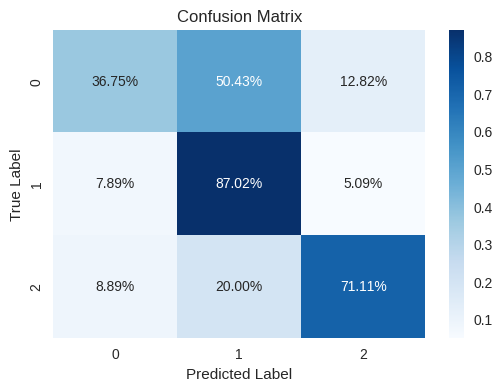

Test Sensitivity: 0.9169, Test Specificity: 0.4216


<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


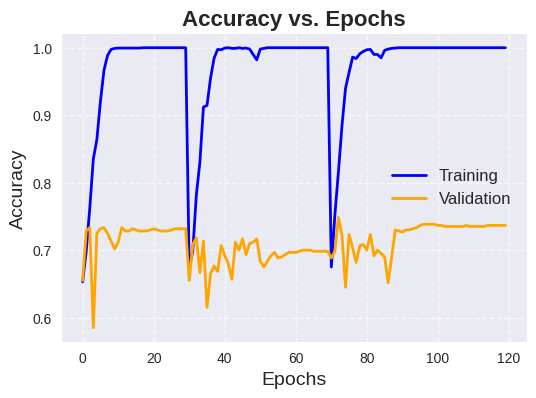

<ipython-input-9-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


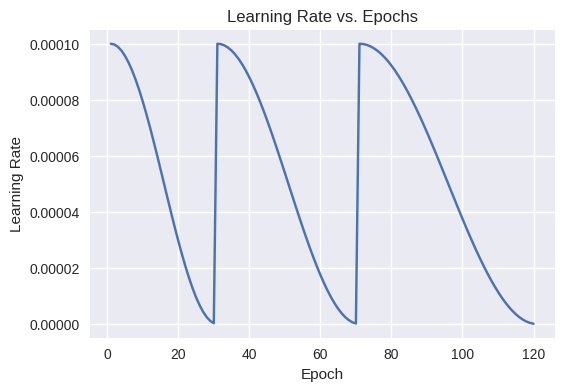

In [14]:
ensemble_models = snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device)